# Codigo Simulacion


## Descripción de la simulación 

El objetivo del código de este sprint es especificar una serie de parámetros (número de paradas, distancia entre
paradas, distribución de probabilidad para la llegada de pasajeros, etc.) y luego ejecuta el
simulación. Al final, se puede acceder a varias estadísticas y analizarlas.

La distancia entre dos paradas sucesivas y la velocidad de los autobuses entre dos paradas son constantes.

Consideramos que hay una primera y una última parada. Un autobús llega vacío en la primera parada a una frecuencia constante (por ejemplo, un autobús cada 20 minutos). En cada parada, excepto en la primera, los pasajeros entran al autobús y los pasajeros salen. En la primera solo pueden entrar. En la última parada, no entran pasajeros y todos los pasajeros deben salir. En el caso de que todos los pasajeros en una parada no puedan abordar el autobús porque está lleno, los pasajeros se seleccionan por orden de llegada. En otras palabras, los pasajeros están esperando el autobús en una cola tipo primero en entrar, primero en salir (FIFO), mientras esperan el autobus

En cada parada, los pasajeros llegan siguiendo una distribución de Poisson. El destino de un pasajero se selecciona al azar agregando uno a una variable normal promedio positiva y una desviación estándar truncada a cero. 

Los costos operativos para que un autobús viaje en el circuito son por ejemplo 500 dólares. El costo de un boleto de autobús para un pasajero, independientemente de la distancia recorrida, es de por ejemplo 2 dólares. Para ser rentable, cada autobús debe transportar al menos 250 pasajeros por circuito. Si la rentabilidad fuera el único factor, la estrategia óptima se obtendría maximizando el número de pasajeros atendidos. Para hacer esto, la frecuencia debe ser lo suficientemente pequeña como para que los autobuses estén casi siempre llenos, pero lo suficientemente grande como para que el número total de pasajeros se mueva alto.

Si se adopta esta estrategia, las colas en cada parada probablemente serán muy largas y el tiempo de servicio para cada pasajero probablemente será muy largo. Los pasajeros estarán insatisfechos y abandonarán el transporte público en beneficio de su automóvil, lo que provocará una disminución de la rentabilidad a largo plazo. Por lo tanto, una estrategia inteligente debe tener en cuenta no solo la rentabilidad de cada autobús, sino también la satisfacción de los clientes.

### Función de satisfacción

Un cliente no estará contento si tiene que esperar el autobús durante mucho tiempo. Una vez en el autobús, se supone que la duración del viaje no influye en su apreciación del servicio. Supongamos que la satisfacción de un cliente, en una escala de 0 (muy insatisfecho) a 1 (muy satisfecho), está dada por 

$$S(t) = \frac{1}{2} \left(1 - \tanh\left(\frac{1}{10}(t - \gamma )\right)\right).$$

Para un planificador, estas simulaciones pueden ayudar a determinar el precio de un boleto de autobús y la frecuencia de los autobuses. Cuanto mayor es la frecuencia, más satisfechos están los clientes, pero mayores son los costos de los autobuses. Al ajustar los parámetros de la simulación, podemos encontrar un compromiso entre la rentabilidad y la calidad del servicio.

## Importacion de librerias

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import heapq
import matplotlib
from operator import itemgetter
import random

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm

Text(0, 0.5, 'Satisfacción')

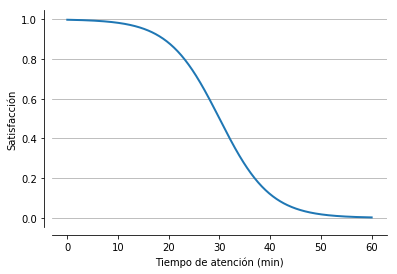

In [2]:
from buslinesim import PrettyFig
x = np.linspace(0, 60, 500)
y = 0.5 * (1 - np.tanh(0.1*(x - 30)))
fig = plt.figure(FigureClass=PrettyFig)
plt.plot(x, y, linewidth=2)
plt.xlabel("Tiempo de atención (min)")
plt.ylabel("Satisfacción")

Se puede ver en la anterior gráfica anterior que si el trabajador espera pocos minutos entre 0 y 10 min, la satisfaccion es cercana a 1, pero si lleva esperando por el autobus entre 50 y 60 min, la satisfaccion es cercana a 0.

### Función de satisfacción para tiempo de llegada

Text(0, 0.5, 'Satisfacción')

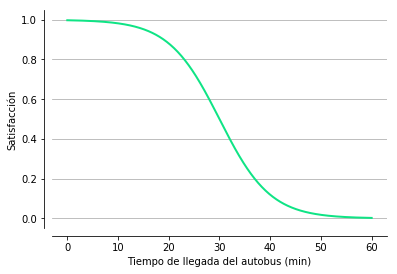

In [3]:
from buslinesim import PrettyFig
x = np.linspace(0, 60, 500)
y = 0.5 * (1 - np.tanh(0.1*(x - 30)))
fig = plt.figure(FigureClass=PrettyFig)
plt.plot(x, y, linewidth=2, color='#0FE485')
plt.xlabel("Tiempo de llegada del autobus (min)")
plt.ylabel("Satisfacción")

## Clase para hacer gráficas

In [4]:
class PrettyFig(matplotlib.figure.Figure):
    """Produce subplots similar to R's default plots.  This class only
    redefines ``matplotlib.figure.Figure``'s ``add_subplot`` method.  Only the
    left and bottom spines are shown, and they are positioned 8 pixels away
    from the plot region.  Moreover, the y-grid is turned on.

    Example
    -------
    To use this custom class, just pass the ``FigureClass`` argument to the
    ``plt.figure`` command.

        >>> x = np.linspace(0, 60, 500)
        >>> y = 0.5 * (1 - np.tanh(0.1*(x - 30)))
        >>> fig = plt.figure(FigureClass=PrettyFig)
        >>> plt.plot(x, y, linewidth=2)
        >>> plt.xlabel("Temps d'attente (min)")
        >>> plt.ylabel("Satisfaction")

    """
    def add_subplot(self, *args, **kwargs):
        ax = super(PrettyFig, self).add_subplot(*args, **kwargs)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.grid(axis='y')
        for loc, spine in ax.spines.items():
            if loc in ['left', 'bottom']:
                spine.set_position(('outward', 8))  # outward by 10 points
            elif loc in ['right', 'top']:
                spine.set_color('none')  # don't draw spine
            else:
                raise ValueError('unknown spine location: {}'.format(loc))
        return ax


## Clase Pasajero

La clase Pasajero sirve principalmente como para almacenar información sobre la hora en que el pasajero ingresó al sistema, la hora en que esperó el autobús, la hora en que dejó el sistema, y su fuente y destino. Segun estos datos permitira calcular su nivel de satisfacción en el sistema

## Atributos

    source: int
        Índice de la parada de autobús en la que el pasajero ingresa al sistema.

    dest: int
        Índice de la parada de autobús en la que el pasajero abandona el sistema.

    time_waited_for_bus: float
       Tiempo entre el momento en que el pasajero ingresa al sistema y el momento
         un autobús con puestos disponibles llega a la parada y recoge al pasajero

    satisfaction: float
        La satisfacción del pasajero con el servicio. 0 está absolutamente insatisfecho y
        1 está perfectamente satisfecho

    start_time: float
        Hora a la que el pasajero llega a su parada de autobús de origen.

    end_time: float
        Hora a la que el pasajero sale del autobús.


In [5]:
class Passenger:
    def __init__(self, source=None, dest=None, start_time=0):
        self.source = source
        self.dest = dest
        self.time_waited_for_bus = None
        self.time_puntualidad = None 
        self.satisfaction = 1.0
        self.start_time = start_time
        self.end_time = None

    def satisfy(self):
        """Sigmoid satisfaction function."""
        self.satisfaction = (
            0.5 * (1 - np.tanh(0.1*(self.time_waited_for_bus - 30))))
        
    def impuntual(self):
        self.time_puntualidad = (
            0.5 * (1 - np.tanh(0.1*(self.time_puntualidad - 30))))

## Clase Autobus

La clase de autobús contiene información sobre la posición y el número de pasajeros. Es responsable de permitir que los pasajeros entren y salgan del autobús.

## Atributos

    active: boolean
         Si el bus está en circulación entre los dos terminales, está activo.
         Si el autobús no comenzó su ejecución o llegó a la última terminal y
         vació a todos sus pasajeros, está inactivo.

    position: float
        Posición del autobús a lo largo de la ruta.

    next_stop: int
        Índice de la próxima parada en la ruta del autobús.

    passengers: lista de Pasajeros

    size: int
         Es la capacidad, número máximo de pasajeros que pueden caber en el autobús.

    last: boolean   
         Indica si este bus es el último en la simulación. Esto es
         se usa para indicar el final de la simulación. Todos los autobuses excepto el último.
         debería tener esta propiedad establecida en False.

    total_passengers: int
           Número total de pasajeros que el autobús transportó durante su recorrido hasta el momento. Esta
         el número incluye no solo a los pasajeros que se encuentran actualmente en el autobús, sino también
         todos los pasajeros que ya salieron del autobus.



In [6]:
class Bus:

    def __init__(self):
        self.active = False
        self.position = 0.0
        self.next_stop = 0
        self.passengers = []
        self.size = 30
        self.last = False
        self.total_passengers = 0

    @property
    def nb_free_places(self):
        """Return the number of places remaining in the bus."""
        return self.size - len(self.passengers)

    def hop_in(self, passengers):
        """Move ``passengers`` inside the bus.  ``passengers`` can be a single
        passenger or a list of passengers."""
        if np.iterable(passengers):
            self.passengers.extend(passengers)
            self.total_passengers += len(passengers)
        else:
            self.passengers.append(passengers)
            self.total_passengers += 1

    def hop_out(self, stop_index, cur_time, hop_out_time):
        """Passengers that reached their destination leave the bus.

        Arguments
        ---------

        stop_index: int
            Index of the stop at which the bus currently is.

        cur_time: float
            Current time in the simulation.

        hop_out_time: function
            Time it takes for a single passenger to leave the bus.  This
            function takes no argument.

        Returns
        -------

        t: float
            Time for passengers to leave the bus.

        out_passengers: list of ``Passengers``
            Passengers that left the bus.

        """
        out_passengers = [passenger for passenger in self.passengers
                          if passenger.dest == stop_index]
        t = 0.0
        for passenger in out_passengers:
            passenger.end_time = cur_time
            self.passengers.remove(passenger)
            t += hop_out_time()
        return t, out_passengers

    def empty(self, cur_time):
        """This function is called when the bus reaches the last stop.  All the
        passengers hop out of the bus.

        Returns
        -------

        out_passengers: list of ``Passengers``
            Passengers that left the bus.

        """
        for passenger in self.passengers:
            passenger.end_time = cur_time
            passenger.dest = self.next_stop
        out_passengers = self.passengers
        self.passengers = []
        self.active = False
        return out_passengers

## Clase Parada de Autobus

Una parada de autobús se encuentra en algún lugar a lo largo de la ruta. Nuevos pasajero llegar a la parada de acuerdo con alguna distribución especificada. Cuando un autobús llega a la parada, los pasajeros se suben al autobús siguiendo una política del primero que llega, primer en ser servido, es decir, una cola FIFO.

## Atributos


    passengers: list of ``Passengers``
        Pasajeros que actualmente están esperando en la parada del autobús. Esta lista representa la cola

    position: float
        Posición de la parada a lo largo de la ruta.

    next_arrival_time: function
        Cantidad de tiempo antes de que el próximo pasajero llegue a la parada. Por ejemplo, si los pasajeros
         llegan de acuerdo con un proceso de Poisson, el tiempo entre llegadas es distribuido exponencialmente.
         Es de decir de personas/min, esto es min/personas

    index: int
        Índice de la parada de autobús a lo largo de la ruta.



In [7]:
class BusStop:
    
    def __init__(self, position=0, arrival_func=lambda: 10.0, index=0):
        self.passengers = []
        self.position = position
        self.next_arrival_time = arrival_func  # tiempo entre llegadas
        self.index = index

        
    def passenger_arrival(self, cur_time, dest):
        """Add a new passenger to the queue.

        Arguments
        ---------

        cur_time: float
            Current time in the simulation.

        dest: int
            Index of the bus stop where the passenger wants to go.

        """
        passenger = Passenger(source=self.index,
                              dest=dest,
                              start_time=cur_time)
        self.passengers.append(passenger)

    def hop_in_bus(self, cur_time, hop_in_time, bus):
        """A bus arrives, all passengers that fit into the bus hop in, others
        stay at the bus stop.
        Arguments
        ---------
        cur_time: float
            Current time in the simulation.
        hop_in_time: function
            Time for one passenger to hop into the bus.  This function takes no
            argument.
        bus: ``Bus``
            Bus that arrives at the stop and into which passengers hop.
        Returns
        -------
        t: float
            Time it takes for passengers to hop into the bus.
        """
        
        nb_to_bus = min(bus.nb_free_places, len(self.passengers))
        t = 0.0
        for i in range(nb_to_bus):
            passenger = self.passengers.pop(0)
            passenger.time_waited_for_bus = cur_time - passenger.start_time
            passenger.satisfy()
            bus.hop_in(passenger)
            t += hop_in_time()
        return t

In [8]:
list_list =[]

# Clase Estadisticas

Este objeto recopila varias estadísticas sobre la simulación actual.

## Atributos

    t: lista de tiempos
        Momentos en que se tomaron las medidas.

    nb_active_buses: lista de enteros
        Número de autobuses activos en cada momento. 

    nb_passengers_in_active_buses: lista de arrays de enteros
        contiene el número de pasajeros en cada bus activo. 

    len_queues_at_stop: lista  de enteros
        contiene el número de pasajeros que esperan en
        cada parada de la ruta.
        
    travel_times: lista de floats
        Lista del tiempo que cada pasajero estuvo en el sistema, es decir, desde el momento
        el pasajero llegó a una parada de autobús a la hora en que esperaba salir del
        Bus en su destino. Solo pasajeros para los cuales el viaje total
        Se sabe el tiempo se tienen en cuenta. La longitud de esta lista es la
        Número total de pasajeros que llegaron a su destino.

    waited_times: lista de floats
        Lista del tiempo en que cada pasajero esperaba un autobús. 

    nb_stops_traveled: lista de enteros
        Número de paradas entre el origen y el destino para cada
        pasajero. 

    satisfacción: lista de floats
        Satisfacción de cada pasajero. La longitud de esta lista es el total
        cantidad de pasajeros que ingresaron al sistema.

    total_passengers: lista de matrices de entradas
        Número total de pasajeros atendidos en cada momento. 

    distance_between_successive_buses: lista de matrices de flotadores
        distancia entre autobuses activos sucesivos. 



In [9]:
class Stats:

    def __init__(self):
        self.t = []
        self.nb_active_buses = []
        self.nb_passengers_in_active_buses = []
        self.len_queues_at_stops = []
        self.travel_times = []
        self.waited_times = []
        self.nb_stops_traveled = []
        self.satisfaction = []
        self.total_passengers = []
        self.distance_between_successive_buses = []

    def measure(self, cur_time, buses, stops, passengers):
        """Measure all quantities.  Quantities that depend on time are appended
        to the appropriate list.  Quantities that do not depend on time are
        recalculated.

        """
        self.t.append(cur_time)
        active_buses = [bus for bus in buses if bus.active]
        self.nb_active_buses.append(len(active_buses))
        self.nb_passengers_in_active_buses.append(
            np.array([len(bus.passengers) for bus in active_buses]))
        self.len_queues_at_stops.append(
            np.array([len(stop.passengers) for stop in stops]))
        self.total_passengers.append(
            np.array([bus.total_passengers for bus in buses]))
        self.travel_times = np.array([passenger.end_time - passenger.start_time
                                      for passenger in passengers
                                      if passenger.end_time is not None])
        self.waited_times = np.array([passenger.time_waited_for_bus
                                      for passenger in passengers
                                      if passenger.time_waited_for_bus
                                      is not None])
        self.nb_stops_traveled = np.array([passenger.dest - passenger.source
                                           for passenger in passengers])
        self.satisfaction = np.array([passenger.satisfaction
                                      for passenger in passengers])
        positions = sorted([bus.position for bus in active_buses])
        #print('Esta es posicion', positions)
        list_list.append((sim.stats.t[-1], positions))
        self.distance_between_successive_buses.append(np.diff(positions))

    def _nb_bins(self, x):
        """Asigna los bins o intervalos del histograma usando la regla Rice Rule"""
        x = np.array(x)
        return np.ceil(2 * x ** (1.0/3.0))

    def plot_travel_times(self, **kwargs):
        """Grafica un histograma de tiempos de viaje."""
        plt.hist(self.travel_times, bins=int(self._nb_bins(len(self.travel_times))),**kwargs)
        plt.xlabel('Total de tiempo de viaje')
        plt.ylabel('Frecuencia de personas')

    def plot_waited_times(self, **kwargs):
        """Grafica un histograma de tiempos de espera."""
        plt.hist(self.waited_times, bins=int(self._nb_bins(len(self.waited_times))), **kwargs)
        plt.xlabel('Tiempo de espera en una parada')
        plt.ylabel('Frecuencia de personas')

    def plot_stops_traveled(self, **kwargs):
        """
        Grafica un histograma del numero de paradas entre el origen y el destino del pasajero
        
        """
        plt.hist(self.nb_stops_traveled, bins=int(self._nb_bins(len(self.nb_stops_traveled))), **kwargs)
        plt.xlabel('Numero de paradas recorridas por los pasajeros')
        plt.ylabel('Frecuencia de personas')

    def plot_mean_nb_passengers(self, **kwargs):
        """
        Grafica el promedio del numero de pasajeros en autobuses activos en funcion del tiempo 
        
        """
        avg_nb_passengers = [nb_passengers.mean()
                             for nb_passengers
                             in self.nb_passengers_in_active_buses]
        plt.plot(self.t / 60.0, avg_nb_passengers, linewidth=2, **kwargs)
        plt.xlabel('Tiempo en horas (h)')
        plt.ylabel('Promedio de pasajeros por bus')

    def plot_total_passengers(self, **kwargs):
        """
        Grafica el numero total de pasajeros en funcion del tiempo
        """
        plt.plot(self.t / 60.0, np.sum(self.total_passengers, axis=1),
                 linewidth=2, **kwargs)
        plt.xlabel('Tiempo en horas (h)')
        plt.ylabel('Total numero de pasajeros')

    def plot_nb_active_buses(self, **kwargs):
        """Grafica el numero de buses activos en funcion del tiempo"""
        plt.plot(self.t / 60.0, self.nb_active_buses, linewidth=2, **kwargs)
        plt.xlabel('Tiempo en horas (h)')
        plt.ylabel('Numbero de buses activos')

    def plot_length_queues(self, **kwargs):
        """Grafica un grafico de barra con la media de las colas de cada parada"""
        queues = np.array(self.len_queues_at_stops)
        nb_stops = np.size(queues, 1)
        plt.bar(np.arange(nb_stops) - 0.5, np.mean(queues, axis=0),
                width=1.0, **kwargs)
        plt.xlim(-0.75, nb_stops - 1.25)
        plt.xlabel('Indice de la parada')
        plt.ylabel('Promedio de la cantidad de pasajeros')

    def plot_total_passengers_per_bus(self, **kwargs):
        """Graficar un histograma con el total numero de pasajeros por bus """
        
        plt.hist(self.total_passengers[-1], bins=int(self._nb_bins(len(self.total_passengers[-1]))), **kwargs)
        plt.xlabel('Total numero de pasajeros por autobus')
        plt.ylabel('Frecuencia')

    def plot_satisfaction(self, **kwargs):
        """Grafica de histograma de la satisfaccion por pasajero."""
        plt.hist(self.satisfaction, bins=int(self._nb_bins(len(self.satisfaction))), **kwargs)
        plt.xlabel('Probabilidad de Satisfaccion')
        plt.ylabel('Frecuencia de personas')

    def plot(self, **kwargs):
        """Plotea las 9 subplots en una sola grafica"""
        self.t = np.array(self.t)
        fig = plt.figure(figsize=(12, 9), FigureClass=PrettyFig)
        fig.add_subplot(3, 3, 1)
        self.plot_travel_times(**kwargs)
        fig.add_subplot(3, 3, 2)
        self.plot_waited_times(**kwargs)
        fig.add_subplot(3, 3, 3)
        self.plot_stops_traveled(**kwargs)
        fig.add_subplot(3, 3, 4)
        self.plot_mean_nb_passengers(**kwargs)
        fig.add_subplot(3, 3, 5)
        self.plot_total_passengers(**kwargs)
        fig.add_subplot(3, 3, 6)
        self.plot_nb_active_buses(**kwargs)
        fig.add_subplot(3, 3, 7)
        self.plot_length_queues(**kwargs)
        fig.add_subplot(3, 3, 8)
        self.plot_total_passengers_per_bus(**kwargs)
        fig.add_subplot(3, 3, 9)
        self.plot_satisfaction(**kwargs)
        fig.subplots_adjust(wspace=0.5, hspace=0.5)


In [10]:
class AnimBus(Bus):
    def __init__(self):
        super(AnimBus, self).__init__()
        self.vjitter = np.random.uniform(-2, 2)    


class AnimStats(Stats):
    def measure(self, cur_time, buses, stops, passengers):
        super(AnimStats, self).measure(cur_time, buses, stops, passengers)
        global counter
        fig = plt.figure(FigureClass=PrettyFig)
        print('Tiempo', sim.stats.t)
        print('Parada', [stop.position for stop in stops])
        plt.bar([stop.position for stop in stops],
                [len(stop.passengers) for stop in stops],
                width=1.5)
        for bus in [bus for bus in buses if bus.active]:
            print('Autobus', bus.position)
            tiempos = sim.stats.t
            dict = {'tiempo en minutos': tiempos, 'posicion del autobus': bus.position}  
            dataframe = pd.DataFrame(dict) 
            dataframe
            plt.plot(bus.position, 16 + bus.vjitter, '>',
                     color='#A60628',
                     markersize=3 + len(bus.passengers)**(2.0/3.0))
        plt.text(26, 19, '{:.0f} min'.format(cur_time))
        plt.xlim(0, 50)
        plt.ylim(0, 20)
        plt.xlabel('Distancia en kilometros entre paradas (km)')
        plt.ylabel('Numero de pasajeros')
        #plt.title('Simulacion horas pico')
        plt.text(19, 20, 'llegada de personas media de 10 minutos.')
        plt.text(19, 21, 'intervalo bajo (cada 15 min sale un bus)')
        plt.text(19, 22, 'Numero de autobuses: 10')
        plt.text(1, 21, 'Simulación hora pico sin colas largas')

        plt.savefig('anim/fig{:05d}.png'.format(counter))
        print('anim/fig{:05d}.png'.format(counter))
        counter += 1


# Clase Evento:

    La simulación funciona procesando eventos. Se produce un evento en un
     tiempo específico `` e_time`` e involucra un objeto específico `` e_obj``.
     Comparar dos eventos equivale a descubrir qué evento ocurre primero.

In [11]:
class Event:

    def __init__(self, e_time, e_obj):
        self.e_time = e_time
        self.e_obj = e_obj

    def __lt__(self, other):
        return self.e_time < other.e_time

In [12]:
class Simulation:
    """A simulation takes care of creating the buses, bus stops and passengers.
    It then execute a sequence of events until the last bus reaches the last
    stop at which point the simulation ends.

    Initialization
    --------------

    A simulation can be initialized with

    >>> sim = Simulation()

    The default values for the simulation are defined to give something
    reasonable, but they should be tuned based on available data.  By default,
    a simulation assumes time is measured in minutes, distance in kilometers
    and speed in kilometers per minute.  The full list of initialization
    options follows.

    bus_stop_positions: list or array
        Position of all bus stops in the simulation.  The number of bus stops
        is set equal to the length of this list.

        Default: ``np.arange(0, 30, 3)``

    passenger_arrival_times: function
        Time between two successive arrivals of passengers at a bus stop.  This
        function takes no arguments.

        Default: ``lambda: np.random.exponential(10.0)``

    hop_in_time: function
        Time for a passenger to hop into a bus.  This function takes no
        arguments.

        Default: ``lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2)``

    hop_out_time: function
        Time for a passenger to hop out of a bus.  This function takes no
        arguments.

        Default: ``lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2)``

    nb_stops_to_dest: function
        Number of stops between origin and destination for a passenger.  This
        function takes no arguments.

        Default: ``lambda: np.round(truncnorm.rvs(-1, 4, loc=4, scale=3))``

    bus_speed: function
        Bus speed between two successive stops.  This function takes no
        argument.

        Default: ``lambda: truncnorm.rvs(-2, 2, loc=0.83, scale=0.1)``

    nb_buses: int
        Number of buses in the simulation.

    time_between_buses: function
        Time between the arrival of two successive buses at the first bus stop.
        This function takes no argument.

        Default: ``lambda: 25``

    stats_time: float
        Time between measurement of statistics.

        Default: 5.0

    Statistics
    ----------

    Once the simulation has finished running, the statistics are available in
    the ``Stats`` object ``sim.stats``.

    Example
    -------

    >>> stop_pos = np.arange(0, 30, 2)
    >>> nb_stops = len(stop_pos)
    >>> mean_stops = nb_stops / 2.0
    >>> std_stops = nb_stops / 4.0
    >>> a = (1 - mean_stops) / std_stops
    >>> b = (nb_stops - mean_stops) / std_stops
    >>> stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
    ...                                                scale=std_stops))
    >>> sim = Simulation(bus_stop_positions=stop_pos,
    ...          time_between_buses=lambda: 40,
    ...          nb_stops_to_dest=stops_to_dest,
    ...          passenger_arrival_times=lambda: np.random.exponential(5.0),
    ...          nb_buses=40)
    >>> sim.run()
    >>> sim.stats.plot()
    >>> print('Mean satisfaction: '
    ...       '{:.3f}'.format(np.mean(sim.stats.satisfaction)))
    >>> print('Mean number of passengers per bus: '
    ...       '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

    """

    def __init__(
            self,
            bus_stop_positions=np.arange(0, 30, 3),
            passenger_arrival_times=lambda: np.random.exponential(10.0),
            hop_in_time=lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2),
            hop_out_time=lambda: truncnorm.rvs(-1, 8, loc=0.3, scale=0.2),
            nb_stops_to_dest=lambda: np.round(truncnorm.rvs(-1, 4, loc=4,
                                                            scale=3)),
            #bus_speed=lambda: truncnorm.rvs(-2, 2, loc=0.83, scale=0.1),
            bus_speed=lambda: truncnorm.rvs(-2, 2, loc=0.83, scale=0.1),
            nb_buses=10,
            time_between_buses=lambda: 25,
            stats_time=1.0):
        # Define stops
        self.bus_stop_positions = bus_stop_positions
        self.stops = [BusStop(position=pos, index=i,
                              arrival_func=passenger_arrival_times)
                      for i, pos in enumerate(self.bus_stop_positions)]
        # last stop, no one hops in
        self.stops[-1].next_arrival_time = lambda: np.Inf

        self.hop_in_time = hop_in_time
        self.hop_out_time = hop_out_time
        self.nb_stops_to_dest = nb_stops_to_dest
        self.bus_speed = bus_speed
        self.nb_buses = nb_buses
        self.time_between_buses = time_between_buses
        self.stats = None
        self.stats_time = stats_time

    def run(self):
        """Run the simulation.  The simulation works by maintaining a heap
        queue of events.  The events are processed until the last bus reaches
        the last stop.

        """
        moved_passengers = []
        events = []

        # Initialize events queue.
        for stop in self.stops:
            heapq.heappush(events, Event(stop.next_arrival_time(), stop))

        buses = []
        # first bus starts early to avoid over accumulation of passengers at
        # bus stops.
        t = 0.5 * self.time_between_buses()
        for i in range(self.nb_buses):
            bus = Bus()
            buses.append(bus)
            heapq.heappush(events, Event(t, bus))
            t += self.time_between_buses()
        buses[-1].last = True

        # Initialize statistics collection.
        self.stats = Stats()
        heapq.heappush(events, Event(self.stats_time, self.stats))

        while events:
            event = heapq.heappop(events)
            t, obj = event.e_time, event.e_obj
            if isinstance(obj, BusStop):
                # New arrival at a bus stop.
                dest = obj.index + self.nb_stops_to_dest()
                obj.passenger_arrival(t, dest=dest)
                heapq.heappush(events, Event(t + obj.next_arrival_time(), obj))
            elif isinstance(obj, Bus):
                if not obj.active:
                    obj.active = True
                if obj.next_stop >= len(self.stops):
                    # Bus reached terminal: it empties and becomes inactive.
                    moved_passengers.extend(obj.empty(t))
                    if obj.last:
                        break
                elif self.stops[obj.next_stop].position == obj.position:
                    # Bus reached a bus stop.
                    bus_stop = self.stops[obj.next_stop]
                    # Passengers hop out.
                    wait_out, passengers = obj.hop_out(
                        stop_index=bus_stop.index,
                        cur_time=t,
                        hop_out_time=self.hop_out_time)
                    moved_passengers.extend(passengers)
                    # Passengers hop in.
                    wait_in = bus_stop.hop_in_bus(t, self.hop_in_time, obj)
                    obj.next_stop += 1
                    heapq.heappush(events, Event(t + wait_out + wait_in, obj))
                else:
                    # Bus finished loading passengers, move to next stop.
                    dist = self.stops[obj.next_stop].position - obj.position
                    heapq.heappush(events,
                                   Event(t + self.bus_speed() * dist, obj))
                    obj.position += dist
            elif isinstance(obj, Stats):
                obj.measure(t, buses, self.stops, moved_passengers)
                heapq.heappush(events, Event(t + self.stats_time, obj))

In [13]:
class AnimSimulation(Simulation):
    def run(self):
        """Run the simulation.  The simulation works by maintaining a heap
        queue of events.  The events are processed until the last bus reaches
        the last stop.

        """
        moved_passengers = []
        events = []

        # Initialize events queue.
        for stop in self.stops:
            heapq.heappush(events, Event(stop.next_arrival_time(), stop))

        buses = []
        # first bus starts early to avoid over accumulation of passengers at
        # bus stops.
        t = 0.5 * self.time_between_buses()
        for i in range(self.nb_buses):
            bus = AnimBus()
            buses.append(bus)
            heapq.heappush(events, Event(t, bus))
            t += self.time_between_buses()
        buses[-1].last = True

        # Initialize statistics collection.
        self.stats = AnimStats()
        heapq.heappush(events, Event(self.stats_time, self.stats))

        while events:
            event = heapq.heappop(events)
            t, obj = event.e_time, event.e_obj
            if isinstance(obj, BusStop):
                # New arrival at a bus stop.
                dest = obj.index + self.nb_stops_to_dest()
                obj.passenger_arrival(t, dest=dest)
                heapq.heappush(events, Event(t + obj.next_arrival_time(), obj))
            elif isinstance(obj, Bus):
                if not obj.active:
                    obj.active = True
                if obj.next_stop >= len(self.stops):
                    # Bus reached terminal: it empties and becomes inactive.
                    moved_passengers.extend(obj.empty(t))
                    if obj.last:
                        break
                elif self.stops[obj.next_stop].position == obj.position:
                    # Bus reached a bus stop.
                    bus_stop = self.stops[obj.next_stop]
                    # Passengers hop out.
                    wait_out, passengers = obj.hop_out(
                        stop_index=bus_stop.index,
                        cur_time=t,
                        hop_out_time=self.hop_out_time)
                    moved_passengers.extend(passengers)
                    # Passengers hop in.
                    wait_in = bus_stop.hop_in_bus(t, self.hop_in_time, obj)
                    obj.next_stop += 1
                    heapq.heappush(events, Event(t + wait_out + wait_in, obj))
                else:
                    # Bus finished loading passengers, move to next stop.
                    dist = self.stops[obj.next_stop].position - obj.position
                    heapq.heappush(events,
                                   Event(t + self.bus_speed() * dist, obj))
                    obj.position += dist
            elif isinstance(obj, Stats):
                obj.measure(t, buses, self.stops, moved_passengers)
                heapq.heappush(events, Event(t + self.stats_time, obj))

counter = 1

## Simulacion con los siguientes parametros
### 15 paradas con 2 Km de distancia entre cada una
### Un headway de 15 min mandar un autobus
### Los pasajeros llegan con una distribcuion exponencial de 5 personas/min
### Con 10 autobuses de capacidad de 30 pasajeros

In [14]:
#stop_pos = np.arange(0, 30, 2)
stop_pos = [ 0,  4,  12,  16,  28, 32, 37, 40]
nb_stops = len(stop_pos)
mean_stops = nb_stops/2.0
std_stops = nb_stops/4.0
a, b = (1 - mean_stops)/std_stops, (nb_stops - mean_stops)/std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops, scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 15,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda : np.random.exponential(10.0),
                 stats_time=1, nb_buses=10)
sim.run()

In [15]:
#Metodo para correr la simulacion

In [16]:
def _nb_bins(x):
    """Use Rice rule for number of bins in histograms."""
    x = np.array(x)
    return np.ceil(2 * x ** (1.0/3.0))

In [17]:
'''def parametros(paradas, intervalo, dist_pasajeros, cant_autobuses, tiempo_screen=1, vel_autobus=0.83):
    """ paradas: (array np) donde cada posicion es la distancia en Km entre una parada y otra
        intervalo: (INT) es cada cuantos minutos un autobus sale min/autobus
        dist_pasajeros: (FLOAT) ""Tiempo entre dos llegadas sucesivas de pasajeros a una parada de autobús min/pasajero
        cant_autobuses: (INT) es la cantidad de autobuses que van a salir en la simulacion
        tiempo_screen: (INT)  "Tiempo en que la simulacion hace un screen para mostrar resultados (por default es cada minuto)
    """
    stop_pos = paradas
    nb_stops = len(stop_pos)
    mean_stops = nb_stops/2.0
    std_stops = nb_stops/4.0
    a, b = (1 - mean_stops)/std_stops, (nb_stops - mean_stops)/std_stops
    stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops, scale=std_stops))
    sim = Simulation(bus_stop_positions=stop_pos,
                     time_between_buses=lambda: intervalo,
                     nb_stops_to_dest=stops_to_dest,
                     passenger_arrival_times=lambda : np.random.exponential(dist_pasajeros),
                     stats_time=1, nb_buses=cant_autobuses, bus_speed=lambda: truncnorm.rvs(-2, 2, loc=vel_autobus, scale=0.1))
    sim.run() 
    diccionario = {'Promedio de satisfaccion de pasajeros (valor entre 0 y 1)':np.mean(sim.stats.satisfaction), 
        'Cantidad de pasajeros que llegaron a su destino':len(sim.stats.travel_times), 
        'Promedio de tiempo de viaje total (tiempo de esperas + tiempo de viaje)':np.mean(sim.stats.travel_times),
        'Cantidad de pasajeros que esperaron': len(sim.stats.waited_times),
        'Promedio de tiempo de de espera en cola':np.mean(sim.stats.waited_times),
        'Media del numero de paradas que recorre cada pasajero':np.mean(sim.stats.nb_stops_traveled),
        'Valor mas frecuente del numero de paradas que recorre cada pasajero':int(stats.mode(sim.stats.nb_stops_traveled)[0]),
        'Numero de intervalos de los histogramas':int(_nb_bins(len(sim.stats.travel_times))),
        'Promedio del numero de pasajeros que llevo un autobus':np.mean(sim.stats.total_passengers[-1])
       }  
    return print(diccionario), sim'''

'def parametros(paradas, intervalo, dist_pasajeros, cant_autobuses, tiempo_screen=1, vel_autobus=0.83):\n    """ paradas: (array np) donde cada posicion es la distancia en Km entre una parada y otra\n        intervalo: (INT) es cada cuantos minutos un autobus sale min/autobus\n        dist_pasajeros: (FLOAT) ""Tiempo entre dos llegadas sucesivas de pasajeros a una parada de autobús min/pasajero\n        cant_autobuses: (INT) es la cantidad de autobuses que van a salir en la simulacion\n        tiempo_screen: (INT)  "Tiempo en que la simulacion hace un screen para mostrar resultados (por default es cada minuto)\n    """\n    stop_pos = paradas\n    nb_stops = len(stop_pos)\n    mean_stops = nb_stops/2.0\n    std_stops = nb_stops/4.0\n    a, b = (1 - mean_stops)/std_stops, (nb_stops - mean_stops)/std_stops\n    stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops, scale=std_stops))\n    sim = Simulation(bus_stop_positions=stop_pos,\n                     time_between_buses=

In [18]:
'''parametros([ 0,  4,  15,  18,  30, 35, 42, 50], 5,15, 15)'''

'parametros([ 0,  4,  15,  18,  30, 35, 42, 50], 5,15, 15)'

In [19]:
sim.stats._nb_bins(32)

7.0

In [20]:
'''#stop_pos = np.arange(0, 30, 2)
stop_pos = [2,4,8,12]
nb_stops = len(stop_pos)
mean_stops = nb_stops / 2.0
std_stops = nb_stops / 4.0
a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
                                               scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 15,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda: np.random.exponential(5),stats_time=1,
                 nb_buses=10)
sim.run()
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))'''

"#stop_pos = np.arange(0, 30, 2)\nstop_pos = [2,4,8,12]\nnb_stops = len(stop_pos)\nmean_stops = nb_stops / 2.0\nstd_stops = nb_stops / 4.0\na, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops\nstops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,\n                                               scale=std_stops))\nsim = Simulation(bus_stop_positions=stop_pos,\n                 time_between_buses=lambda: 15,\n                 nb_stops_to_dest=stops_to_dest,\n                 passenger_arrival_times=lambda: np.random.exponential(5),stats_time=1,\n                 nb_buses=10)\nsim.run()\nsim.stats.plot()\nplt.show()\n\nprint('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))\nprint('Promedio del numero de pasajeros que llevo un autobus: '\n      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))"

### Conversión de tiempo en minutos a formato de datetime

In [21]:
import datetime
import numpy as np

sim.stats.t = np.array(sim.stats.t)
#Definir hora inicial de la simulacion
start_time = '6:01'
#slot_time = 5
tiempos = sim.stats.t.tolist()

hours = []
time = datetime.datetime.strptime(start_time, '%H:%M')
for i in range(len(tiempos)):
    hours.append(time.strftime("%H:%M"))
    time += datetime.timedelta(minutes=sim.stats_time)


#print(hours)
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'horas':hours,'tiempo en minutos': tiempos, 'tiempo en horas': horas }  
    
dfnropastrans = pd.DataFrame(dict) 
    
dfnropastrans

,horas,tiempo en minutos,tiempo en horas
0,06:01,1,0.02
1,06:02,2,0.03
2,06:03,3,0.05
3,06:04,4,0.07
4,06:05,5,0.08
5,06:06,6,0.10
6,06:07,7,0.12
7,06:08,8,0.13
8,06:09,9,0.15
9,06:10,10,0.17


In [22]:
hora = {}
for key, value in zip(tiempos, hours):
    hora[key] = value
hora

{1: '06:01',
 2: '06:02',
 3: '06:03',
 4: '06:04',
 5: '06:05',
 6: '06:06',
 7: '06:07',
 8: '06:08',
 9: '06:09',
 10: '06:10',
 11: '06:11',
 12: '06:12',
 13: '06:13',
 14: '06:14',
 15: '06:15',
 16: '06:16',
 17: '06:17',
 18: '06:18',
 19: '06:19',
 20: '06:20',
 21: '06:21',
 22: '06:22',
 23: '06:23',
 24: '06:24',
 25: '06:25',
 26: '06:26',
 27: '06:27',
 28: '06:28',
 29: '06:29',
 30: '06:30',
 31: '06:31',
 32: '06:32',
 33: '06:33',
 34: '06:34',
 35: '06:35',
 36: '06:36',
 37: '06:37',
 38: '06:38',
 39: '06:39',
 40: '06:40',
 41: '06:41',
 42: '06:42',
 43: '06:43',
 44: '06:44',
 45: '06:45',
 46: '06:46',
 47: '06:47',
 48: '06:48',
 49: '06:49',
 50: '06:50',
 51: '06:51',
 52: '06:52',
 53: '06:53',
 54: '06:54',
 55: '06:55',
 56: '06:56',
 57: '06:57',
 58: '06:58',
 59: '06:59',
 60: '07:00',
 61: '07:01',
 62: '07:02',
 63: '07:03',
 64: '07:04',
 65: '07:05',
 66: '07:06',
 67: '07:07',
 68: '07:08',
 69: '07:09',
 70: '07:10',
 71: '07:11',
 72: '07:12',
 

## Como las distancias entre las paradas son constantes, lo que hace que varie el tiempo de llegada es la velocidad del autobus. list_list contiene toda la simulacion en listas.

In [23]:
resultados = []
temp = None
tiempo = None
for element in list_list:
    for tupla in element:
        
        if type(tupla) == list:
            if temp != tupla:
                temp = tupla
                resultados.append((tiempo, tupla))
        else:
            tiempo = tupla
            
resultados

[(1, []),
 (8, [0.0]),
 (9, [4.0]),
 (13, [12.0]),
 (20, [16.0]),
 (23, [0.0, 16.0]),
 (24, [4.0, 28.0]),
 (28, [12.0, 28.0]),
 (35, [16.0, 28.0]),
 (37, [16.0, 32.0]),
 (38, [0.0, 28.0, 32.0]),
 (39, [4.0, 28.0, 32.0]),
 (41, [4.0, 28.0, 37.0]),
 (43, [12.0, 28.0, 37.0]),
 (47, [12.0, 28.0, 40.0]),
 (49, [12.0, 32.0, 40.0]),
 (50, [16.0, 32.0]),
 (52, [16.0, 37.0]),
 (53, [0.0, 28.0, 37.0]),
 (54, [4.0, 28.0, 37.0]),
 (57, [4.0, 28.0, 40.0]),
 (58, [12.0, 28.0, 40.0]),
 (60, [12.0, 28.0]),
 (63, [12.0, 32.0]),
 (64, [16.0, 32.0]),
 (68, [0.0, 16.0, 37.0]),
 (69, [4.0, 28.0, 37.0]),
 (73, [12.0, 28.0, 37.0]),
 (74, [12.0, 28.0, 40.0]),
 (77, [12.0, 28.0]),
 (79, [16.0, 28.0]),
 (80, [16.0, 32.0]),
 (82, [28.0, 32.0]),
 (83, [0.0, 28.0, 32.0]),
 (85, [4.0, 28.0, 37.0]),
 (89, [12.0, 28.0, 37.0]),
 (93, [12.0, 28.0, 40.0]),
 (94, [12.0, 32.0, 40.0]),
 (95, [12.0, 32.0]),
 (96, [16.0, 32.0]),
 (98, [4.0, 16.0, 37.0]),
 (101, [4.0, 28.0, 37.0]),
 (102, [12.0, 28.0, 40.0]),
 (105, [12.0, 28

In [52]:
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'Minuto en la que un bus llega a la estacion ':[ i[0] for i in resultados] ,'Estacion del autobus (Km)': [ i[1] for i in resultados] }  
    
dfcambios = pd.DataFrame(dict) 
    
dfcambios

,Minuto en la que un bus llega a la estacion,Estacion del autobus (Km)
0,1,[]
1,8,[0.0]
2,9,[4.0]
3,13,[12.0]
4,20,[16.0]
5,23,"[0.0, 16.0]"
6,24,"[4.0, 28.0]"
7,28,"[12.0, 28.0]"
8,35,"[16.0, 28.0]"
9,37,"[16.0, 32.0]"


In [53]:


tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'Minuto en la que un bus llega a la estacion ':[ int(np.random.normal(i[0], 1)) for i in resultados] ,'Estacion del autobus (Km)': [ i[1] for i in resultados] }  
    
dfcambios = pd.DataFrame(dict) 
    
dfcambios


,Minuto en la que un bus llega a la estacion,Estacion del autobus (Km)
0,0,[]
1,7,[0.0]
2,8,[4.0]
3,13,[12.0]
4,20,[16.0]
5,23,"[0.0, 16.0]"
6,24,"[4.0, 28.0]"
7,26,"[12.0, 28.0]"
8,35,"[16.0, 28.0]"
9,37,"[16.0, 32.0]"


In [54]:
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
X = get_truncated_normal(mean=int(8, sd=2, low=8, upp=10)


SyntaxError: unexpected EOF while parsing (<ipython-input-54-725ee47e0ab4>, line 3)

In [38]:
[i[0]+2 for i in resultados]

[3,
 10,
 11,
 15,
 22,
 25,
 26,
 30,
 37,
 39,
 40,
 41,
 43,
 45,
 49,
 51,
 52,
 54,
 55,
 56,
 59,
 60,
 62,
 65,
 66,
 70,
 71,
 75,
 76,
 79,
 81,
 82,
 84,
 85,
 87,
 91,
 95,
 96,
 97,
 98,
 100,
 103,
 104,
 107,
 110,
 113,
 115,
 116,
 117,
 119,
 122,
 124,
 126,
 129,
 130,
 133,
 134,
 137,
 141,
 145,
 149,
 150,
 154,
 155,
 157,
 159,
 162,
 163,
 166,
 171,
 177,
 182]

In [27]:
X = get_truncated_normal(mean=int([i[0] for i in resultados], sd=2, low=8, upp=10)
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]
dict = {'Minuto en la que un bus llega a la estacion ':[ abs(int(X.rvs())) for i in resultados]
 ,'Estacion del autobus (Km)': [ i[1] for i in resultados] }  
    
dfcambios = pd.DataFrame(dict) 
    
dfcambios

SyntaxError: invalid syntax (<ipython-input-27-7d6355da3336>, line 6)

In [29]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

for j in resultados:
    for i[0] in j: 
        print(i)




TypeError: 'int' object does not support item assignment

In [30]:
resultados2 = []
temp = None
tiempo = None
for element in list_list:
    for tupla in element:
        
        if type(tupla) == list:
            if temp != tupla:
                temp = tupla
                X = get_truncated_normal(mean=8, sd=2, low=1, upp=50)
                resultados2.append(X.rvs())
        else:
            tiempo = tupla
            
resultados2

[8.21694039293166,
 3.3001319408665486,
 9.162860495148715,
 8.91787212154588,
 10.780072706145654,
 9.035035209950564,
 8.926403318419547,
 9.971949876950243,
 9.16171051328355,
 7.5910267137879615,
 8.13730515081211,
 7.653477326145876,
 4.5403400212561165,
 6.553708288357978,
 8.767889569398887,
 9.31831697512264,
 10.722147920620282,
 9.507681428198756,
 10.557958702017343,
 9.837891573892513,
 7.8033755075025955,
 8.15545384497742,
 10.138782291042434,
 6.725386206703495,
 8.694514844930168,
 7.665726297665678,
 4.94599480080145,
 8.429188056474816,
 9.254258716163458,
 6.689483387475188,
 8.203307986598103,
 9.656312729871697,
 11.067452874048396,
 9.167566184274786,
 7.77186561145358,
 5.355111356756328,
 7.791360344200051,
 6.2044263000977145,
 7.971885806336762,
 7.262913134414169,
 9.725447915590669,
 9.49475059417024,
 8.272059427353044,
 7.450880402860929,
 8.212577943758715,
 8.542551061512611,
 7.469278938125215,
 8.132365054797917,
 7.806810069840802,
 9.7678838078418,
 

In [28]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
X = get_truncated_normal(mean=8, sd=2, low=8, upp=10)


In [31]:
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'Minuto en la que un bus llega a la estacion ':resultados2,'Estacion del autobus (Km)': [ i[1] for i in resultados] }  
    
dfcambios = pd.DataFrame(dict) 
    
dfcambios

,Minuto en la que un bus llega a la estacion,Estacion del autobus (Km)
0,8.216940,[]
1,3.300132,[0.0]
2,9.162860,[4.0]
3,8.917872,[12.0]
4,10.780073,[16.0]
5,9.035035,"[0.0, 16.0]"
6,8.926403,"[4.0, 28.0]"
7,9.971950,"[12.0, 28.0]"
8,9.161711,"[16.0, 28.0]"
9,7.591027,"[16.0, 32.0]"


### Aqui no deberia de correr otra simulacion, sino ponerle distribuciones random a la anterior en los tiempos

In [ ]:
#stop_pos = np.arange(0, 30, 2)
stop_pos = [ 0,  4,  12,  16,  28, 32, 37, 40]
nb_stops = len(stop_pos)
mean_stops = nb_stops/2.0
std_stops = nb_stops/4.0
a, b = (1 - mean_stops)/std_stops, (nb_stops - mean_stops)/std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops, scale=std_stops))
sim = AnimSimulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 15,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda : np.random.exponential(10.0),
                 stats_time=1, nb_buses=10, bus_speed=lambda: 1)
sim.run()


In [ ]:
list_list

In [ ]:
resultados2 = []
temp = None
tiempo = None
for element in list_list:
    for tupla in element:
        
        if type(tupla) == list:
            if temp != tupla:
                temp = tupla
                resultados2.append((tiempo, tupla))
        else:
            tiempo = tupla
            
resultados2

In [ ]:
sim.stats.t = np.array(sim.stats.t)
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'Hora en la que un bus llega a la estacion ':[ i[0] for i in resultados2] ,'Estacion del autobus sim 2 (Km)': [ i[1] for i in resultados2] }  
    
dfcambios2 = pd.DataFrame(dict) 
    
dfcambios2

In [ ]:
temp = None
list2= []
for i in resultados:
    for vector in i:
        if type(vector) == list:
            print(vector)

In [ ]:
count=0
temp = None
list2 = []
for i in resultados:
    for vector in i:
        if type(vector) == list:
            for j in enumerate(vector):
                for i in stop_pos:
                    if j[1]==i:
                        count+=1
                        list2.append((temp, j))
                    
        else:
            temp = vector 
                    
list2.sort(key=itemgetter(1))                     
print(list2)

In [ ]:
len(list2)

In [ ]:
count=0
temp = None
list3 = []
for i in resultados2:
    for vector in i:
        if type(vector) == list:
            for j in enumerate(vector):
                for i in stop_pos:
                    if j[1]==i:
                        count+=1
                        list3.append((temp, j))
                    
        else:
            temp = vector 
                    
 
list3.sort(key=itemgetter(1))
print(list3)


In [ ]:
list3

In [ ]:
print([i[1][1] for i in list3])

In [ ]:
for list in range(0,len(list3)-len(list2)):
    list2.append(('nada', 'nada'))

In [ ]:
list2

In [ ]:
print([i[0] for i in list3])

In [ ]:
print([i[1] for i in list3])

In [ ]:
len([i[1][0] for i in list3])

In [ ]:
len(list2)

In [ ]:
[i[1][0] for i in list2] 

In [ ]:
dict2 = {'Minuto en que debió llegar': [ i[0] for i in list2] ,'Minuto en que llegó': [i[0] for i in list3]}
dfcambios2 = pd.DataFrame(dict2)

dfcambios2

In [ ]:
dfcambios2 = dfcambios2[dfcambios2['Minuto en que debió llegar'] !='nada']
dfcambios2['diferencia']=dfcambios2['Minuto en que debió llegar'] - dfcambios2['Minuto en que llegó']
dfcambios2['diferencia']= dfcambios2['diferencia'].abs()
dfcambios2

In [ ]:
for i in resultados2:
    for vector in i:
        print(vector)

In [ ]:
resultados2

In [ ]:
for i in resultados2:
    for vector in i[1]:
        print(vector)

In [ ]:
a = [[4, 3, 2], [12, 5, 2], [4,6,7]]
b = ['a', 'b', 'c']
print([i for i in enumerate(b)])


In [ ]:
for l in a:
    for i in enumerate(l):
        print('index:', i[0], 'item:', i[1])

## Indicador: Tiempos en el sistema (Tiempo de espera + Tiempo de servicio)
Es un array de floats
Lista del tiempo de cada pasajero que estuvo en el sistema (min) (Cuenta el tiempo de espera en Cola)
La longitud es el numero de pasajeros transportados a su destino

In [20]:

print('Indicador tiempo de espera + Tiempo de servicio')
print('Cantidad de pasajeros que llegaron a su destino: {}'.format(len(sim.stats.travel_times)), 'pasajeros')
print('Media del tiempo de los pasajeros en el sistema(incluyendo tiempo en cola): {:.3f}'.format(np.mean(sim.stats.travel_times)), 'min')
print('Numero de intervalos del histograma: {}'.format(int(_nb_bins(len(sim.stats.travel_times)))), 'intervalos')

Indicador tiempo de espera + Tiempo de servicio
Cantidad de pasajeros que llegaron a su destino: 119 pasajeros
Media del tiempo de los pasajeros en el sistema(incluyendo tiempo en cola): 25.989 min
Numero de intervalos del histograma: 10 intervalos


In [21]:
len(sim.stats.travel_times)

119

In [22]:
tiempo_en_sistema = {"Number people": sim.stats.travel_times }
dftiempo_en_sistema = pd.DataFrame(tiempo_en_sistema)
dftiempo_en_sistema = dftiempo_en_sistema['Number people'].value_counts(sort=False, bins=int(_nb_bins(len(sim.stats.travel_times)))).to_frame()
dftiempo_en_sistema

,Number people
"(4.191999999999999, 8.966]",5
"(8.966, 13.691]",9
"(13.691, 18.416]",18
"(18.416, 23.141]",21
"(23.141, 27.866]",13
"(27.866, 32.592]",19
"(32.592, 37.317]",20
"(37.317, 42.042]",4
"(42.042, 46.767]",3
"(46.767, 51.493]",7


In [23]:
_nb_bins(len(sim.stats.travel_times))

10.0

In [24]:
len(sim.stats.travel_times)/_nb_bins(len(sim.stats.travel_times))

11.9

In [25]:
_nb_bins(len(sim.stats.travel_times))

10.0

In [28]:
tiempo_en_sistema = {"Tiempo de viaje total (tiempo de servicio + tiempo de espera)": sim.stats.travel_times, 'Intervalo': int(_nb_bins(len(sim.stats.travel_times))) }
dftiempo_en_sistema = pd.DataFrame(tiempo_en_sistema)

dftiempo_en_sistema

def tiempodeviajetotal():
    '''
    Retorna los tiempos de viaje total (tiempo de servicio + tiempo de espera)
    Retorna el numero de intervalos para hacer el histograma
    '''
    return sim.stats.travel_times, int(_nb_bins(len(sim.stats.travel_times)))

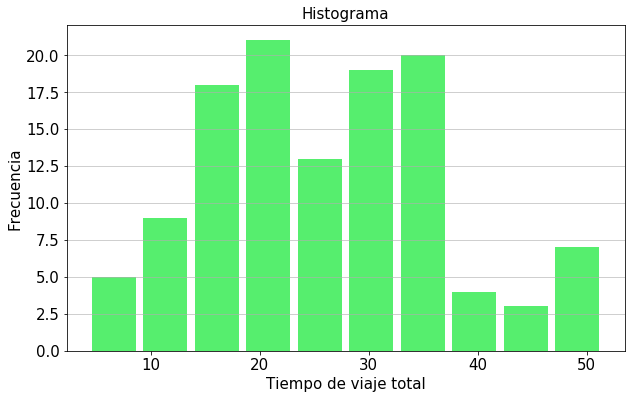

In [29]:
plt.figure(figsize=[10,6])
n, bins, patches = plt.hist(x=sim.stats.travel_times, bins=int(_nb_bins(len(sim.stats.travel_times))), color='#0FE731',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Tiempo de viaje total',fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)
plt.title('Histograma',fontsize=15)
plt.show()

## Indicador: Tiempos de Espera
Lista del tiempo en que cada pasajero esperaba un autobús. 

In [31]:
print('Cantidad de pasajeros que esperaron: {}'.format(len(sim.stats.waited_times)), 'pasajeros')
print('Media del tiempo de los pasajeros de espera en la cola: {:.3f}'.format(np.mean(sim.stats.waited_times)), 'min')
print('Numero de intervalos del histograma: {}'.format(int(_nb_bins(len(sim.stats.waited_times)))), 'intervalos')

Cantidad de pasajeros que esperaron: 119 pasajeros
Media del tiempo de los pasajeros de espera en la cola: 8.841 min
Numero de intervalos del histograma: 10 intervalos


In [32]:
len(sim.stats.waited_times)

119

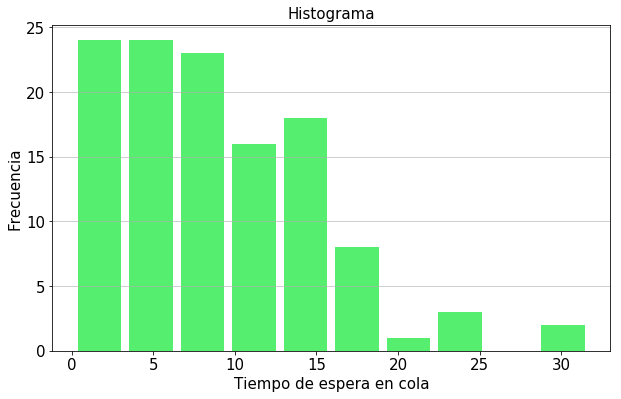

In [33]:
plt.figure(figsize=[10,6])
n, bins, patches = plt.hist(x=sim.stats.waited_times, bins=int(_nb_bins(len(sim.stats.waited_times))), color='#0FE731',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Tiempo de espera en cola',fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)
plt.title('Histograma',fontsize=15)
plt.show()

## Indicador:  Nro de paradas recorridas en el viaje para cada pasajeros

In [34]:
print('Media del numero de paradas que recorre cada pasajero: {:.3f}'.format(np.mean(sim.stats.nb_stops_traveled)), 'paradas')
print('Valor mas frecuente del numero de paradas que recorre cada pasajero: {}'.format(int(stats.mode(sim.stats.nb_stops_traveled)[0])), 'paradas','.Este valor aparece', int(stats.mode(sim.stats.nb_stops_traveled)[1]), 'veces' )
print('Numero de intervalos del histograma: {}'.format(int(_nb_bins(len(sim.stats.nb_stops_traveled)))), 'intervalos')

Media del numero de paradas que recorre cada pasajero: 3.286 paradas
Valor mas frecuente del numero de paradas que recorre cada pasajero: 3 paradas .Este valor aparece 40 veces
Numero de intervalos del histograma: 10 intervalos


In [35]:
sim.stats.nb_stops_traveled

array([4., 1., 5., 4., 3., 3., 3., 3., 6., 6., 5., 4., 4., 4., 3., 3., 2.,
       2., 2., 2., 2., 2., 3., 5., 3., 3., 6., 1., 5., 3., 8., 4., 4., 3.,
       2., 4., 6., 6., 2., 2., 2., 4., 3., 2., 1., 1., 1., 3., 5., 5., 4.,
       3., 3., 3., 5., 3., 3., 2., 3., 3., 2., 2., 2., 4., 2., 1., 4., 4.,
       3., 3., 3., 2., 2., 4., 3., 3., 5., 4., 4., 4., 3., 3., 3., 2., 2.,
       2., 4., 3., 5., 4., 3., 3., 3., 6., 3., 2., 2., 2., 4., 3., 3., 1.,
       6., 4., 3., 3., 8., 6., 5., 3., 2., 2., 1., 4., 3., 5., 3., 2., 2.])

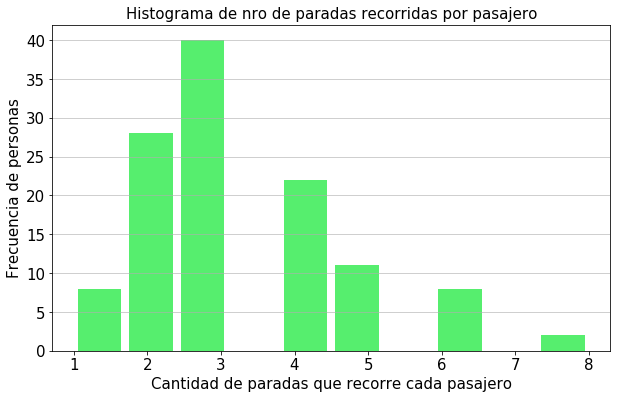

In [36]:
plt.figure(figsize=[10,6])
n, bins, patches = plt.hist(x=sim.stats.nb_stops_traveled, bins=int(_nb_bins(len(sim.stats.nb_stops_traveled))), color='#0FE731',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Cantidad de paradas que recorre cada pasajero',fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frecuencia de personas',fontsize=15)
plt.title('Histograma de nro de paradas recorridas por pasajero',fontsize=15)
plt.show()

## Indicador:   Nro de pasajeros en buses activos 

In [37]:
avg_nb_passengers = [nb_passengers.mean() for nb_passengers in sim.stats.nb_passengers_in_active_buses]


C:\Users\alema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
C:\Users\alema\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [65]:
sim.stats.nb_passengers_in_active_buses

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([4]),
 array([4]),
 array([4]),
 array([4]),
 array([4]),
 array([4]),
 array([7]),
 array([7]),
 array([7]),
 array([7]),
 array([7]),
 array([9, 4]),
 array([9, 4]),
 array([9, 4]),
 array([9, 4]),
 array([9, 4]),
 array([9, 4]),
 array([9, 6]),
 array([9, 6]),
 array([9, 6]),
 array([9, 6]),
 array([11,  6]),
 array([11,  6]),
 array([11,  6]),
 array([11,  8]),
 array([11,  8]),
 array([9, 8, 1]),
 array([9, 8, 1]),
 array([9, 8, 1]),
 array([9, 7, 2]),
 array([9, 7, 2]),
 array([9, 7, 2]),
 array([14,  7,  2]),
 array([14,  7,  2]),
 array([14,  7,  2]),
 array([14,  7,  2]),
 array([14,  7,  2]),
 array([7, 3]),
 array([7, 3]),
 array([7, 3]),
 array([9, 4]),
 array([9, 4, 0]),
 array([9, 4, 0]),
 array([9, 4, 0]),
 array([7, 4, 1]),
 a

In [39]:
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]
dict = {'tiempo en minutos': tiempos, 'tiempo en horas': horas, 'Nro de pasajeros en Buses Activos': avg_nb_passengers}  
dfnropasajbuses = pd.DataFrame(dict) 
dfnropasajbuses.head(50)

,tiempo en minutos,tiempo en horas,Nro de pasajeros en Buses Activos
0,1,0.02,NaN
1,2,0.03,NaN
2,3,0.05,NaN
3,4,0.07,NaN
4,5,0.08,NaN
5,6,0.10,NaN
6,7,0.12,NaN
7,8,0.13,2.000000
8,9,0.15,2.000000
9,10,0.17,2.000000


C:\Users\alema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Grafica media de pasajeros por autobus')

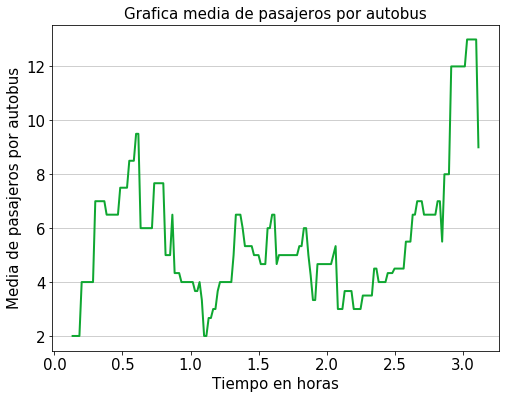

In [73]:
avg_nb_passengers = [nb_passengers.mean() for nb_passengers in sim.stats.nb_passengers_in_active_buses]
plt.figure(figsize=[8,6])
plt.plot(sim.stats.t / 60.0, avg_nb_passengers, linewidth=2,  color='#0FA731')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Tiempo en horas',fontsize=15)
plt.ylabel('Media de pasajeros por autobus',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Grafica media de pasajeros por autobus',fontsize=15)


## Indicador: Total de número de pasajeros transportados

In [41]:
len(sim.stats.t)

187

In [42]:
type(sim.stats.t.tolist())

list

In [45]:
len(sim.stats.total_passengers)

187

In [ ]:
sim.stats.total_passengers

Text(0.5, 1.0, 'Grafica total numero de pasajeros')

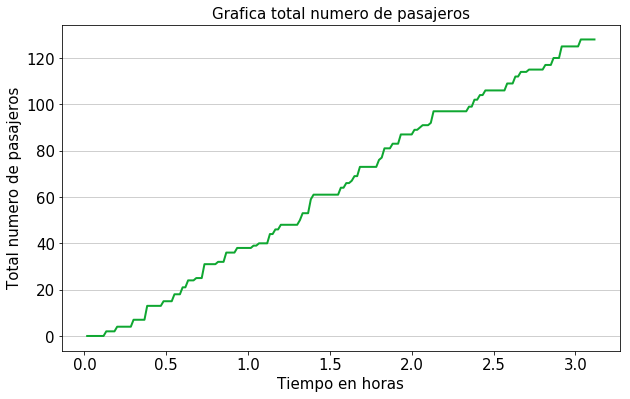

In [47]:
plt.figure(figsize=[10,6])
plt.plot(sim.stats.t / 60.0, np.sum(sim.stats.total_passengers, axis=1), linewidth=2,  color='#0FA731')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Tiempo en horas',fontsize=15)
plt.ylabel('Total numero de pasajeros',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Grafica total numero de pasajeros',fontsize=15)

## Indicador: Nro. de buses Activos

In [48]:
len(sim.stats.nb_active_buses)

187

In [49]:
len(sim.stats.t)

187

In [50]:
lista = sim.stats.nb_active_buses
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'tiempo en minutos': tiempos, 'tiempo en horas': horas, 'autobuses activos': lista}  
    
dfnrobuses = pd.DataFrame(dict) 
    
dfnrobuses  

,tiempo en minutos,tiempo en horas,autobuses activos
0,1,0.02,0
1,2,0.03,0
2,3,0.05,0
3,4,0.07,0
4,5,0.08,0
5,6,0.10,0
6,7,0.12,0
7,8,0.13,1
8,9,0.15,1
9,10,0.17,1


Text(0.5, 1.0, 'Grafica numero de buses activos')

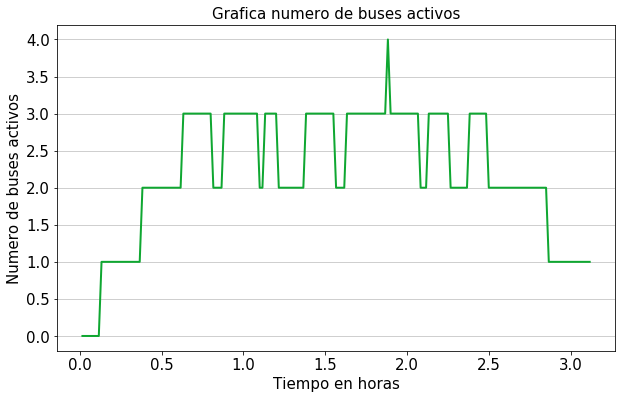

In [51]:
plt.figure(figsize=[10,6])
plt.plot(sim.stats.t / 60.0, sim.stats.nb_active_buses, linewidth=2,  color='#0FA731')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Tiempo en horas',fontsize=15)
plt.ylabel('Numero de buses activos',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Grafica numero de buses activos',fontsize=15)

Text(0.5, 1.0, 'Gráfica número de buses activos')

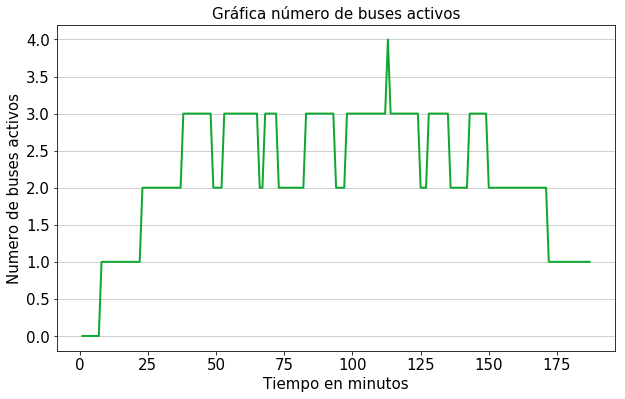

In [52]:
plt.figure(figsize=[10,6])
plt.plot(sim.stats.t , sim.stats.nb_active_buses, linewidth=2,  color='#0FA731')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Tiempo en minutos',fontsize=15)
plt.ylabel('Numero de buses activos',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Gráfica número de buses activos',fontsize=15)

## Indicador cola por parada

In [53]:
sim.stats.len_queues_at_stops
tiempos = sim.stats.t.tolist()
horas= sim.stats.t/60
horas = horas.tolist()
horas = [ '%.2f' % elem for elem in horas ]

dict = {'tiempo en minutos': tiempos, 'tiempo en horas': horas, 'cola por parada': sim.stats.len_queues_at_stops,'suma de todas las colas': np.sum(sim.stats.len_queues_at_stops, axis=1)}  
    
dfcolaporparada = pd.DataFrame(dict) 
    
dfcolaporparada  

,tiempo en minutos,tiempo en horas,cola por parada,suma de todas las colas
0,1,0.02,"[0, 0, 0, 0, 1, 0, 0, 0]",1
1,2,0.03,"[0, 1, 1, 0, 1, 0, 0, 0]",3
2,3,0.05,"[1, 1, 1, 0, 1, 0, 0, 0]",4
3,4,0.07,"[1, 1, 1, 0, 1, 0, 0, 0]",4
4,5,0.08,"[2, 2, 1, 0, 1, 0, 0, 0]",6
5,6,0.10,"[2, 2, 1, 0, 1, 0, 0, 0]",6
6,7,0.12,"[2, 2, 1, 0, 1, 0, 0, 0]",6
7,8,0.13,"[0, 2, 2, 0, 1, 0, 0, 0]",5
8,9,0.15,"[1, 2, 2, 0, 1, 0, 0, 0]",6
9,10,0.17,"[1, 2, 2, 0, 1, 0, 0, 0]",6


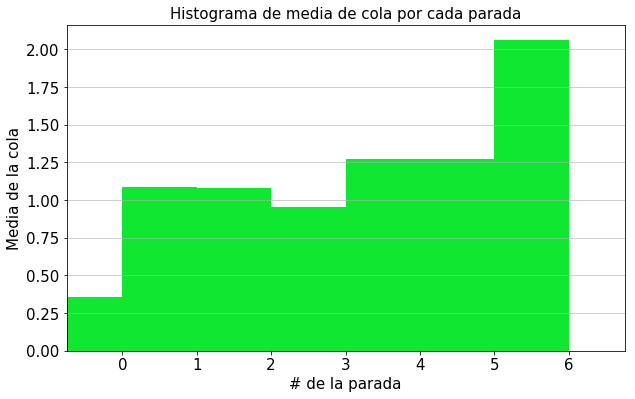

In [153]:
plt.figure(figsize=[10,6])
queues = np.array(sim.stats.len_queues_at_stops)
nb_stops = np.size(queues, 1)
plt.bar(np.arange(nb_stops) - 0.5, np.mean(queues, axis=0), width=1.0,  color='#0FE731')
plt.xlim(-0.75, nb_stops - 1.25)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('# de la parada',fontsize=15)
plt.ylabel('Media de la cola',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Histograma de media de cola por cada parada',fontsize=15)
plt.show()

In [54]:
sim.stats.len_queues_at_stops

[array([0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 1, 1, 0, 1, 0, 0, 0]),
 array([1, 1, 1, 0, 1, 0, 0, 0]),
 array([1, 1, 1, 0, 1, 0, 0, 0]),
 array([2, 2, 1, 0, 1, 0, 0, 0]),
 array([2, 2, 1, 0, 1, 0, 0, 0]),
 array([2, 2, 1, 0, 1, 0, 0, 0]),
 array([0, 2, 2, 0, 1, 0, 0, 0]),
 array([1, 2, 2, 0, 1, 0, 0, 0]),
 array([1, 2, 2, 0, 1, 0, 0, 0]),
 array([1, 2, 2, 0, 1, 0, 0, 0]),
 array([1, 0, 2, 0, 2, 0, 1, 0]),
 array([1, 1, 2, 0, 2, 0, 1, 0]),
 array([2, 1, 2, 2, 2, 0, 1, 0]),
 array([2, 1, 2, 2, 2, 0, 1, 0]),
 array([2, 1, 2, 2, 2, 1, 1, 0]),
 array([2, 1, 3, 2, 2, 1, 1, 0]),
 array([3, 1, 0, 2, 2, 1, 1, 0]),
 array([4, 2, 0, 2, 2, 1, 1, 0]),
 array([4, 2, 0, 2, 2, 1, 2, 0]),
 array([4, 2, 1, 2, 2, 1, 3, 0]),
 array([4, 2, 1, 2, 2, 1, 3, 0]),
 array([0, 2, 1, 0, 2, 1, 3, 0]),
 array([1, 2, 1, 0, 2, 1, 3, 0]),
 array([1, 2, 1, 0, 2, 1, 3, 0]),
 array([1, 2, 1, 0, 2, 1, 4, 0]),
 array([1, 2, 1, 0, 2, 1, 4, 0]),
 array([1, 2, 1, 0, 2, 2, 5, 0]),
 array([1, 0, 1, 0, 3, 2, 6, 0]),
 array([1, 0, 

# Indicador: Total de número de pasajeros que llevó un autobus

In [55]:
np.sum(sim.stats.total_passengers[-1])

128

In [56]:
sim.stats.total_passengers[-1]

array([20, 14,  6, 10, 18, 16,  5,  6, 15, 18])

In [57]:
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

Promedio del numero de pasajeros que llevo un autobus: 12.80


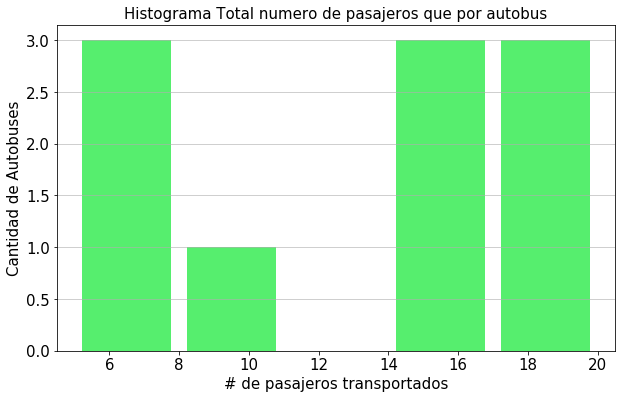

In [58]:
plt.figure(figsize=[10,6])
n, bins, patches = plt.hist(x=sim.stats.total_passengers[-1], bins=int(_nb_bins(len(sim.stats.total_passengers[-1]))), color='#0FE731',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('# de pasajeros transportados',fontsize=15)
plt.ylabel('Cantidad de Autobuses',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Histograma Total numero de pasajeros que por autobus',fontsize=15)
plt.show()

# Indicador: Satisfaccion de los Pasajeros de tiempo de espera

In [63]:
print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))

187

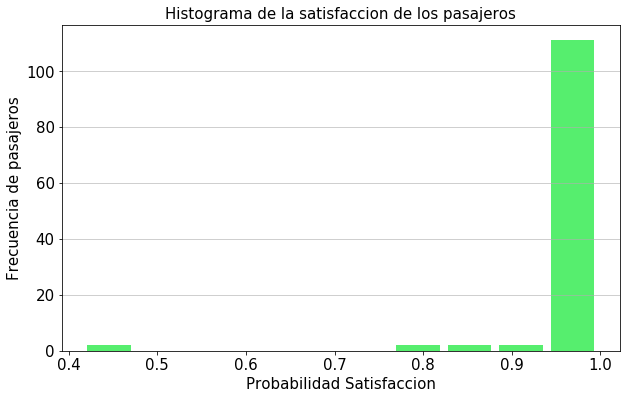

In [60]:
plt.figure(figsize=[10,6])
n, bins, patches = plt.hist(x=sim.stats.satisfaction, bins=int(_nb_bins(len(sim.stats.satisfaction))), color='#0FE731',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probabilidad Satisfaccion',fontsize=15)
plt.ylabel('Frecuencia de pasajeros',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Histograma de la satisfaccion de los pasajeros',fontsize=15)
plt.show()

In [64]:
int(_nb_bins(len(sim.stats.satisfaction)))

10

# Indicador: Satisfaccion de Pasajeros de tiempo de restraso


In [ ]:
plt.figure(figsize=[10,6])
n, bins, patches = plt.hist(x=sim.stats.satisfaction, bins=int(_nb_bins(len(sim.stats.satisfaction))), color='#0FE731',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probabilidad Satisfaccion',fontsize=15)
plt.ylabel('Frecuencia de pasajeros',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Histograma de la satisfaccion de los pasajeros',fontsize=15)
plt.show()

In [ ]:
len(sim.stats.satisfaction)

## Simulacion 2 con los siguientes parametros. SE BAJA EL HEADWAY
### 15 paradas con 2 Km de distancia entre cada una
### Un headway de 5 min mandar un autobus
### Los pasajeros llegan con una distribcuion exponencial de 5 personas/min
### Con 10 autobuses de capacidad de 30 pasajeros

In [ ]:
stop_pos = np.arange(0, 30, 2)
nb_stops = len(stop_pos)
mean_stops = nb_stops / 2.0
std_stops = nb_stops / 4.0
a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
                                               scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 10,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda: np.random.exponential(5),
                 nb_buses=10)
sim.run()
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

## Simulacion 3 con los siguientes parametros. SE BAJA EL HEADWAY Y SUBE DISTRIBUCION DE LOS PASAJEROS
### 15 paradas con 2 Km de distancia entre cada una
### Un headway de 5 min mandar un autobus
### Los pasajeros llegan con una distribcuion exponencial de 10 personas/min
### Con 10 autobuses de capacidad de 30 pasajeros

In [ ]:
stop_pos = np.arange(0, 30, 2)
nb_stops = len(stop_pos)
mean_stops = nb_stops / 2.0
std_stops = nb_stops / 4.0
a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
                                               scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 5,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda: np.random.exponential(10),
                 nb_buses=10)
sim.run()
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

## Simulacion 3 con los siguientes parametros. SE BAJA EL HEADWAY Y SUBE DISTRIBUCION DE LOS PASAJEROS Y BAJA NUMERO DE AUTOBUSES
### 15 paradas con 2 Km de distancia entre cada una
### Un headway de 5 min mandar un autobus
### Los pasajeros llegan con una distribcuion exponencial de 10 personas/min
### Con 10 autobuses de capacidad de 30 pasajeros

In [ ]:
stop_pos = np.arange(0, 30, 2)
print(stop_pos)
nb_stops = len(stop_pos)
mean_stops = nb_stops / 2.0
std_stops = nb_stops / 4.0
a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
                                               scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 5,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda: np.random.exponential(10),
                 nb_buses=5)
sim.run()
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

## Simulacion 3 con los siguientes parametros. SUBE EL HEADWAY
### 15 paradas con 2 Km de distancia entre cada una
### Un headway de 45 min mandar un autobus
### Los pasajeros llegan con una distribcuion exponencial de 10 personas/min
### Con 5 autobuses de capacidad de 30 pasajeros

In [ ]:
stop_pos = np.arange(0, 30, 2)
nb_stops = len(stop_pos)
mean_stops = nb_stops / 2.0
std_stops = nb_stops / 4.0
a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops,
                                               scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 45,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda: np.random.exponential(10),
                 nb_buses=5)
sim.run()
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

## Si es una hora pico

In [ ]:
parametros(np.arange(0, 30, 2), 45, 20, 10)

In [ ]:
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

In [ ]:
sim.stats.t

In [ ]:
stop_pos = np.arange(0, 30, 2)
nb_stops = len(stop_pos)
mean_stops = nb_stops / 2.0
std_stops = nb_stops / 4.0
a, b = (1 - mean_stops) / std_stops, (nb_stops - mean_stops) / std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops, scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda:30 ,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda: np.random.exponential(5),
                 nb_buses=10)
sim.run()
sim.stats.plot()
plt.show()

print('Promedio de Satisfaccion de los pasajeros: {:.3f}'.format(np.mean(sim.stats.satisfaction)))
print('Promedio del numero de pasajeros que llevo un autobus: '
      '{:.2f}'.format(np.mean(sim.stats.total_passengers[-1])))

In [ ]:
sim.stats.t